# Predictions and data cleaning

Now that we found XGBoost is the optimal model, we can use it for predicting the label for every image in the dataset

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from scifAI.ml.auto_feature_selection import AutoFeatureSelection
from scifAI.utils import list_of_dict_to_dict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier

from sklearn import manifold, datasets
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.dummy import DummyClassifier

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    y_pred_dummy = DummyClassifier().fit(X,y_true).predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("No information rate: %.2f" % accuracy_score(y_true, y_pred_dummy) )
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

In [3]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

now lets load the data

In [4]:
%%time
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
metadata

CPU times: user 2.42 s, sys: 138 ms, total: 2.56 s
Wall time: 2.57 s


,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1,B_cell,0.001350,Experiment_1 Donor_1,False,0
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1,T_cell,0.000959,Experiment_1 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1,Dead_Cell,0.002358,Experiment_1 Donor_1,False,0
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1,T_cell,0.000502,Experiment_1 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1,B_cell_with_small_area,0.028317,Experiment_1 Donor_1,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1,T_cell_with_signaling,0.259178,Experiment_4 Donor_9,False,1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1,B_cell,0.006382,Experiment_4 Donor_9,False,0
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1,T_cell_with_signaling,0.487638,Experiment_4 Donor_9,False,1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1,B_cell,0.082181,Experiment_4 Donor_9,False,2


In [5]:
%%time
df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features

CPU times: user 4min 12s, sys: 11.6 s, total: 4min 23s
Wall time: 4min 24s


,mask_based_area_BF,mask_based_bbox_area_BF,mask_based_convex_area_BF,mask_based_eccentricity_BF,mask_based_equivalent_diameter_BF,mask_based_euler_number_BF,mask_based_extent_BF,mask_based_feret_diameter_max_BF,mask_based_filled_area_BF,mask_based_major_axis_length_BF,...,max_intensity_ratio_MHCII_R7_R8,sum_intensity_ratio_CD3_R7_R8,mean_intensity_ratio_CD3_R7_R8,max_intensity_ratio_CD3_R7_R8,sum_intensity_ratio_P-CD3zeta_R7_R8,mean_intensity_ratio_P-CD3zeta_R7_R8,max_intensity_ratio_P-CD3zeta_R7_R8,sum_intensity_ratio_Live-Dead_R7_R8,mean_intensity_ratio_Live-Dead_R7_R8,max_intensity_ratio_Live-Dead_R7_R8
0,2228,3021,2392,0.484394,53.261409,1,0.737504,61.717096,2228,57.336477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,656,812,689,0.369856,28.900608,1,0.807882,32.756679,656,30.262314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,753,899,780,0.386491,30.963678,1,0.837597,34.132096,753,32.348559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1208,1512,1247,0.661747,39.218279,1,0.798942,51.224994,1208,45.782110,...,19.735296,0.465222,0.465222,25.504583,0.481531,0.481531,26.397369,0.754085,0.754085,45.835530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,973,1190,997,0.100885,35.197473,1,0.817647,37.215588,973,35.332773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065963,3956,5046,4180,0.787555,70.971372,1,0.783987,91.760558,3956,91.437834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065964,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,5.716450,0.190820,0.190820,7.474995,0.115499,0.115499,4.191402,1.000000,1.000000,32.928658
1065965,3388,4272,3670,0.875994,65.679035,1,0.793071,90.426766,3388,96.830707,...,6.247939,0.039196,0.039196,124.378412,0.045108,0.045108,140.202637,0.005466,0.005466,16.385927


to avoid using irrelevant or meaningless features in our analysis, we exclude features which include these strings

In [6]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


In [7]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

# training the model

Now we can train the model with the optimal top-k and all the available data

In [8]:
top_k = 196

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
le = le.fit(metadata.loc[train_index.tolist() + validation_index.tolist() , "label"])

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                 ('xgb', XGBClassifier(n_jobs = -1, 
                                       n_estimators = 100, 
                                       eval_metric = "logloss") )
        ], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist() , classification_indx],  
               le.fit_transform(metadata.loc[train_index.tolist()+ validation_index.tolist()  , "label"])  )

[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  19.0s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   1.9s


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection(top_k=196)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
       

# Model evaluation

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       161
           1       1.00      0.99      0.99       190
           2       0.95      0.93      0.94       154
           3       0.96      0.96      0.96       182
           4       0.87      0.88      0.88       196
           5       0.82      0.86      0.84       147
           6       0.89      0.91      0.90       200
           7       0.95      0.92      0.94       189
           8       0.90      0.82      0.86       148

    accuracy                           0.92      1567
   macro avg       0.91      0.91      0.91      1567
weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
No information rate: 0.13
matthews correlation coeff: 0.90
Cohen Kappa score: 0.90
Accuracy: 0.92 & balanced Accuracy: 0.91
macro F1 score: 0.91 & micro F1 score: 0.92
macro Precision score: 0.91 & micro Precision score: 0.92
macro Re

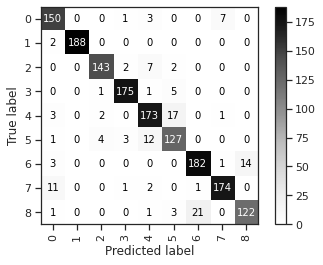

In [13]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               le.transform(metadata.loc[test_index, "label"]))

plt.savefig('Supplementary Figure - confusion matrix best model.png', bbox_inches="tight")
plt.savefig('Supplementary Figure - confusion matrix best model.svg', bbox_inches="tight")

## Teplizumab

In [ ]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")

teplizumab_index = metadata.label.isin(set_of_interesting_classes)
teplizumab_index = teplizumab_index & metadata.condition.isin(["Teplizumab"])
classification_complete_report(xgb, 
                               df_features.loc[teplizumab_index, classification_indx],
                               metadata.loc[teplizumab_index, "label"], labels = set_of_interesting_classes)

plt.savefig('Supplementary Figure - confusion matrix Teplizumab.png', bbox_inches="tight")
plt.savefig('Supplementary Figure - confusion matrix Teplizumab.svg', bbox_inches="tight")

## CD19-TCB

In [ ]:
sns.set(font_scale = 1.0)
sns.set_style("ticks")

tcb_index = metadata.label.isin(set_of_interesting_classes)
tcb_index = tcb_index & metadata.condition.isin(["CD19-TCB"])
classification_complete_report(xgb, 
                               df_features.loc[tcb_index, classification_indx],
                               metadata.loc[tcb_index, "label"], labels = set_of_interesting_classes)

plt.savefig('Supplementary Figure - confusion matrix TCB-CD19.png', bbox_inches="tight")
plt.savefig('Supplementary Figure - confusion matrix TCB-CD19.svg', bbox_inches="tight")

## prediction on images and data cleaning
 
In the first step, we predict the label for all the images

In [14]:
%%time

metadata["prediction"] = xgb.predict( df_features.loc[:, classification_indx] ) 

CPU times: user 17.6 s, sys: 1 s, total: 18.6 s
Wall time: 4.17 s


then kicking out the predictions with high uncertainty using entropy

In [14]:
from scipy.stats import entropy
metadata["entropy"] = entropy(xgb.predict_proba( df_features.loc[:, classification_indx] ), axis=1)

0.007777914325678


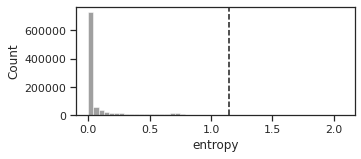

In [15]:

fig, ax = plt.subplots(figsize = (5,2))
ax = sns.histplot(data = metadata, 
                  x = "entropy", 
                  bins = 50, 
                  color = "grey", 
                  ax = ax)

ax.axvline( metadata["entropy"].quantile(0.99), c = "k", ls = "--")
print((metadata["entropy"] >= 1.2).mean())

In [18]:
indx = metadata["entropy"] >= 1.2
metadata.loc[indx,"prediction"] = "high_entropy"
indx = None

finding out of focus images

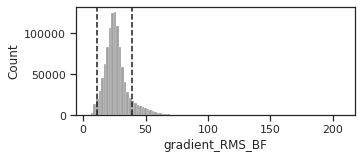

In [17]:

fig, ax = plt.subplots(figsize = (5,2))
ax = sns.histplot(data = df_features, 
                  x = "gradient_RMS_BF", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)

ax.axvline( df_features["gradient_RMS_BF"].quantile(0.02), c = "k", ls = "--")
ax.axvline( df_features["gradient_RMS_BF"].quantile(0.90), c = "k", ls = "--")

In [19]:
indx = df_features.loc[:, "gradient_RMS_BF"] < np.percentile(df_features.loc[:, "gradient_RMS_BF"], 2)
metadata.loc[indx,"prediction"] = "out_of_focus"
print(np.percentile(df_features.loc[:, "gradient_RMS_BF"], 2))

10.756068220781268


In [20]:
indx = df_features.loc[:, "gradient_RMS_BF"] > np.percentile(df_features.loc[:, "gradient_RMS_BF"], 90)
metadata.loc[indx,"prediction"] = "out_of_focus"
print(np.percentile(df_features.loc[:, "gradient_RMS_BF"], 90))

39.31319635911259


selecting the live cells

221.08691436155416


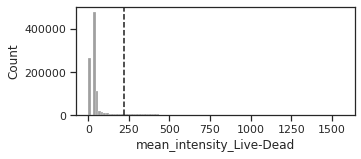

In [21]:
 
fig, ax = plt.subplots(figsize = (5,2))
ax = sns.histplot(data = df_features, 
                  x = "mean_intensity_Live-Dead", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)

ax.axvline( df_features["mean_intensity_Live-Dead"].quantile(0.90), c = "k", ls = "--")
print(df_features["mean_intensity_Live-Dead"].quantile(0.90))

In [22]:
indx = df_features.loc[:, 'mean_intensity_Live-Dead'] > df_features.loc[:, 'mean_intensity_Live-Dead'].quantile(0.90)
metadata.loc[indx , "prediction"] = "Dead_Cell"

filtering the small B cells

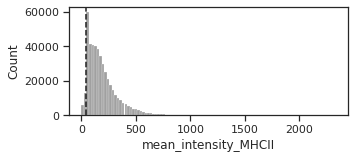

In [23]:

indx = metadata.loc[: , "prediction"] == "B_cell"

fig, ax = plt.subplots(figsize = (5,2))
ax = sns.histplot(data = df_features.loc[indx,:], 
                  x = "mean_intensity_MHCII", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)

ax.axvline( df_features["mean_intensity_MHCII"].quantile(0.05), c = "k", ls = "--")

In [24]:
indx = metadata.loc[: , "prediction"] == "B_cell"
indx = indx & (df_features.loc[:, 'mean_intensity_MHCII'] < df_features.loc[indx, 'mean_intensity_MHCII'].quantile(0.05))
metadata.loc[indx , "prediction"] = "B_cell_with_low_intensity"

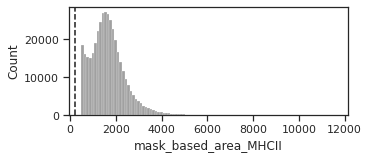

In [27]:
## delteing B cells with small values
indx = metadata.loc[: , "prediction"] == "B_cell"

fig, ax = plt.subplots(figsize = (5,2))
ax = sns.histplot(data = df_features.loc[indx,:], 
                  x = "mask_based_area_MHCII", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)
 
ax.axvline( df_features["mask_based_area_MHCII"].quantile(0.10), c = "k", ls = "--") 

In [26]:
indx = metadata.loc[: , "prediction"] == "B_cell"
indx = indx & (df_features.loc[:, 'mask_based_area_MHCII'] < df_features.loc[indx, 'mask_based_area_MHCII'].quantile(0.10))
metadata.loc[indx , "prediction"] = "B_cell_with_small_area"

filtering the small T cells

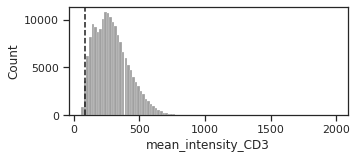

In [29]:
## delteing T cells with small values
fig, ax = plt.subplots(figsize = (5,2))
indx = metadata.loc[: , "prediction"] == "T_cell"
ax = sns.histplot(data = df_features.loc[indx,:], 
                  x = "mean_intensity_CD3", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)

ax.axvline(df_features.loc[indx, 'mean_intensity_CD3'].quantile(0.01), c = "k", ls = "--")

In [30]:
indx = metadata.loc[: , "prediction"] == "T_cell"
indx = indx & (df_features.loc[:, 'mean_intensity_CD3'] < df_features.loc[indx, 'mean_intensity_CD3'].quantile(0.01))
metadata.loc[indx , "prediction"] = "T_cell_with_low_intensity"

filtering the B & T cels one layer with small B cells

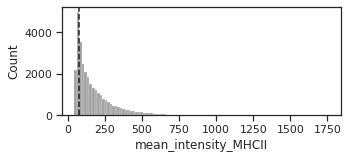

In [32]:

fig, ax = plt.subplots(figsize = (5,2))
indx = metadata.loc[: , "prediction"] == "B_T_cell_in_one_layer"
ax = sns.histplot(data = df_features.loc[indx,:], 
                  x = "mean_intensity_MHCII", 
                  bins = 100, 
                  color = "grey", 
                  ax = ax)

ax.axvline(df_features.loc[indx, 'mean_intensity_MHCII'].quantile(0.20), c = "k", ls = "--")

In [33]:
indx = metadata.loc[: , "prediction"] == "B_T_cell_in_one_layer"
indx = indx & (df_features.loc[:, 'mean_intensity_MHCII'] < df_features.loc[indx, 'mean_intensity_MHCII'].quantile(0.20))
metadata.loc[indx , "prediction"] = "T_cell_with_B_cell_fragments"

In [34]:
metadata["key"] = metadata["experiment"] + " " +  metadata["donor"] 

Now using the set of features previously found as important, we try to run a anomaly detection code

In [40]:

selected_feature_names = ['mask_based_major_axis_length_MHCII',
       'mask_based_major_axis_length_CD3', 'correlation_F-Actin',
       'contrast_P-CD3zeta', 'homogeneity_F-Actin', 'ASM_CD3',
       'mean_intensity_ratio_F-Actin_R5_R6',
       'max_intensity_ratio_MHCII_R5_R6', 'mask_based_solidity_F-Actin',
       'max_intensity_ratio_F-Actin_R5_R6',
       'mask_based_equivalent_diameter_BF', 'dissimilarity_F-Actin',
       'mask_based_eccentricity_CD3',
       'mean_intensity_ratio_P-CD3zeta_R5_R6', 'correlation_CD3',
       'manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta',
       'correlation_P-CD3zeta', 'mask_based_solidity_P-CD3zeta',
       'mean_intensity_P-CD3zeta', 'skew_intensity_P-CD3zeta',
       'correlation_distance_R5_MHCII_R6_CD3', 'dissimilarity_P-CD3zeta',
       'contrast_CD3', 'sum_intensity_CD3',
       'sum_intensity_ratio_MHCII_R5_R6', 'mask_based_eccentricity_BF',
       'homogeneity_BF', 'mask_based_solidity_CD3', 'mask_based_area_CD3',
       'kurtosis_intensity_P-CD3zeta', 'mean_intensity_CD3',
       'skew_intensity_MHCII', 'mask_based_feret_diameter_max_BF',
       'correlation_MHCII', 'mask_based_major_axis_length_P-CD3zeta',
       'mask_based_bbox_area_CD3', 'mean_intensity_ratio_CD3_R5_R6',
       'manders_overlap_coefficient_R5_MHCII_R6_CD3',
       'mean_intensity_ratio_MHCII_R5_R6',
       'mask_based_feret_diameter_max_CD3', 'kurtosis_intensity_CD3',
       'homogeneity_CD3', 'sum_intensity_ratio_CD3_R5_R6',
       'mask_based_eccentricity_F-Actin',
       'structural_similarity_R4_F-Actin_R5_MHCII',
       'max_intensity_ratio_P-CD3zeta_R5_R6', 'mask_based_solidity_MHCII',
       'mean_intensity_F-Actin', 'homogeneity_MHCII',
       'mean_intensity_MHCII', 'contrast_MHCII', 'dissimilarity_MHCII',
       'dissimilarity_CD3', 'skew_intensity_F-Actin',
       'mask_based_extent_BF', 'max_intensity_ratio_CD3_R5_R6',
       'mask_based_major_axis_length_F-Actin',
       'euclidean_distance_R5_MHCII_R6_CD3', 'std_intensity_P-CD3zeta',
       'mask_based_eccentricity_MHCII', 'dice_distance_BF_CD3',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3',
       'mask_based_eccentricity_P-CD3zeta', 'skew_intensity_CD3',
       'sum_intensity_F-Actin', 'correlation_BF']

now we transofrom the data using UMAP to a 2d space, and filter all the small clusters in the data

In [44]:
from sklearn.cluster import DBSCAN
from umap import UMAP

X_transformed = UMAP(n_components=2, n_jobs=-1).fit_transform(StandardScaler().fit_transform(df_features.loc[:, selected_feature_names]))


lets find the optimal eps

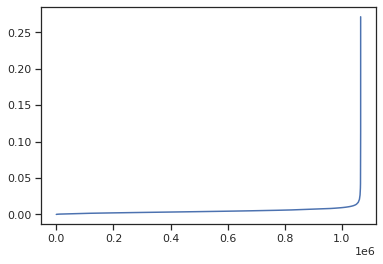

In [56]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_transformed)
distances, indices = nbrs.kneighbors(X_transformed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [57]:
db_scan = DBSCAN(eps = 0.09 ,
                 n_jobs = -1).fit(X_transformed)

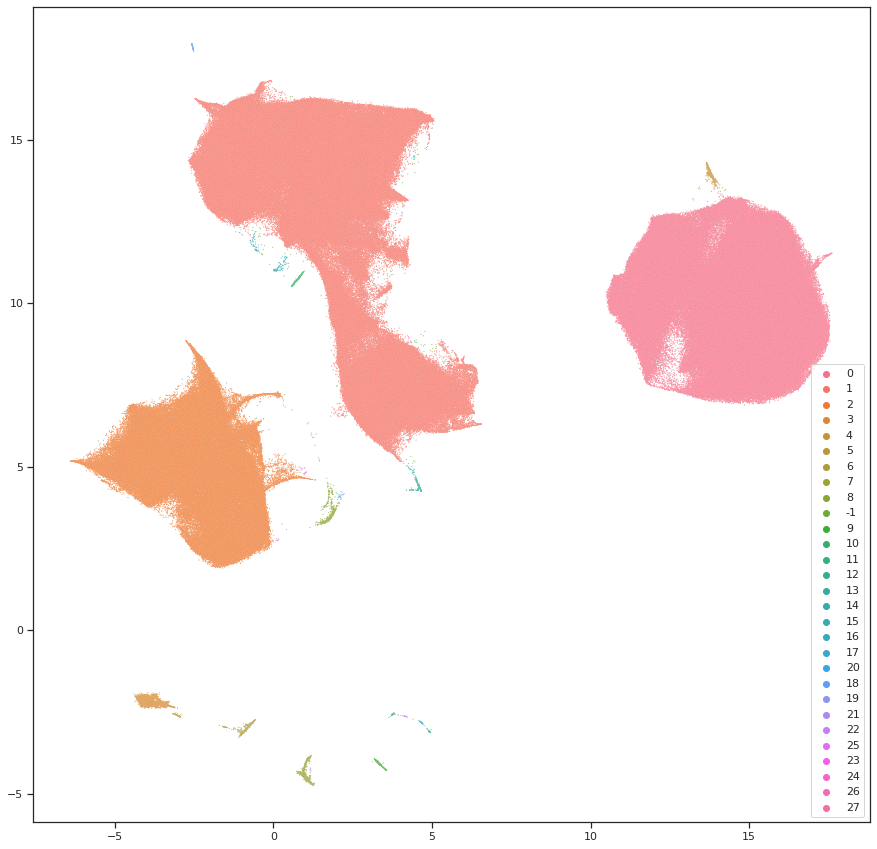

In [58]:
fig , ax = plt.subplots(1, figsize = (15,15) )

ax = sns.scatterplot(x = X_transformed[:,0],
                     y = X_transformed[:,1],
                     hue = db_scan.labels_.astype(str),#  metadata["prediction"]
                     s = 1, 
                     ax = ax )  

In [59]:
metadata["cluster"] = db_scan.labels_
metadata["outlier"] = db_scan.labels_ == -1

In [60]:
X_transformed = None
db_scan = None

Now lets look at the clusters

In [61]:
metadata.cluster.value_counts()/len(metadata)

 1     0.423163
 0     0.358208
 2     0.201629
 3     0.005525
 7     0.003005
 6     0.002825
 9     0.001596
 8     0.001053
 4     0.000874
 11    0.000516
 10    0.000475
 12    0.000274
 13    0.000237
-1     0.000137
 5     0.000097
 18    0.000096
 14    0.000083
 17    0.000056
 15    0.000053
 22    0.000032
 20    0.000019
 26    0.000011
 16    0.000008
 25    0.000008
 24    0.000007
 27    0.000005
 21    0.000005
 19    0.000003
 23    0.000003
Name: cluster, dtype: float64

there are multiple clusters that show a very low sample size, which we will filter them out. Lets look at some of them randomly

                                                      file    experiment  \
1533     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
1864     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
4531     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
4720     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
6124     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1063920  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1064019  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1064149  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1064510  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065915  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set   label  \
1533     Donor_1      +

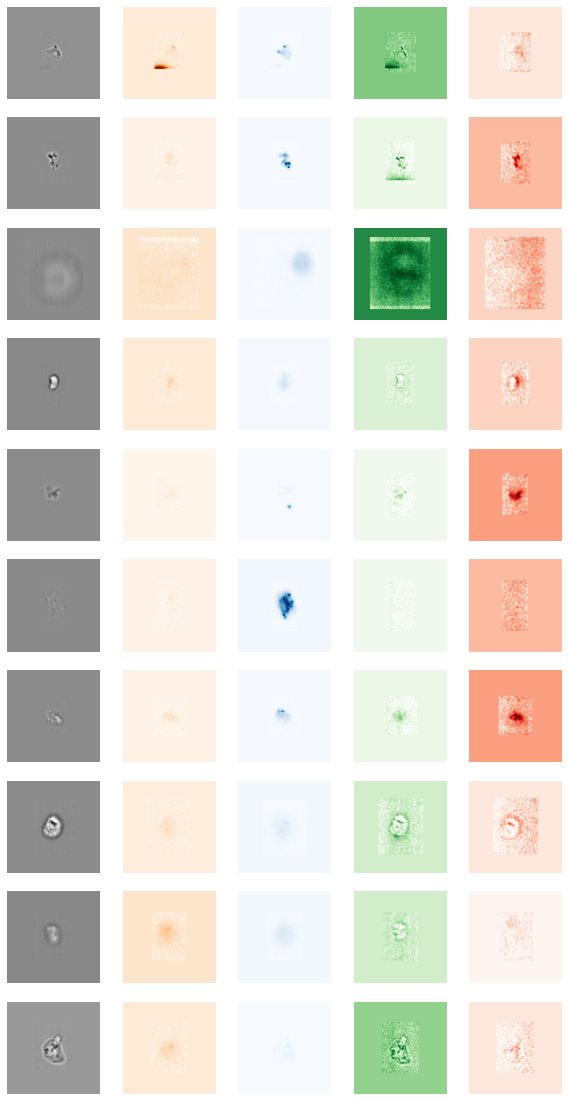

In [63]:
## CLUSTER 
k = 10
image_size = 128
channels_to_be_plotted = [0,3,4,5,6]
channel_colors = ["Greys","Oranges" ,"Blues","Greens","Reds"]

cl = 9    
indx = metadata.cluster == cl
print(metadata.loc[indx, :])
files = metadata.loc[indx, "file"].sample(k,replace=True).tolist()

nrows = k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()


                                                      file    experiment  \
124      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
280      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
710      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
3427     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
3923     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1061520  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1062277  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1063589  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1064000  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065300  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set label prediction  \
124      Donor

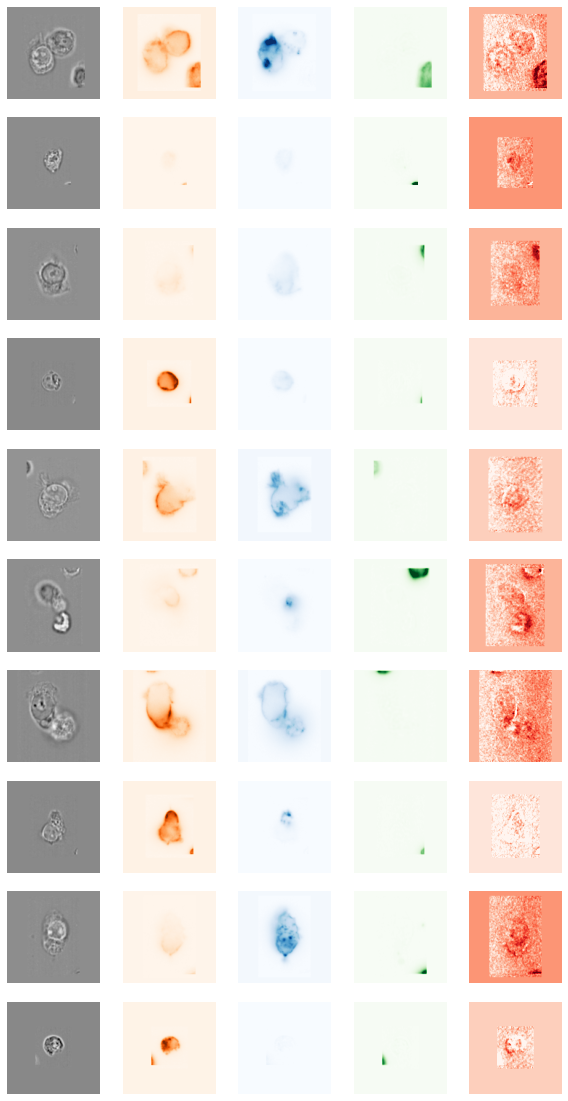

In [64]:

k = 10
image_size = 128
channels_to_be_plotted = [0,3,4,5,6]
channel_colors = ["Greys","Oranges" ,"Blues","Greens","Reds"]

cl = 4    
indx = metadata.cluster == cl
print(metadata.loc[indx, :])
files = metadata.loc[indx, "file"].sample(k,replace=True).tolist()

nrows = k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

#plt.savefig('Figure 2/ sample images.svg', bbox_inches="tight")

                                                      file    experiment  \
46       /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
53       /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
185      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
448      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
469      /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1064665  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065144  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065331  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065345  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065572  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set label  \
46       Donor_1      +SE

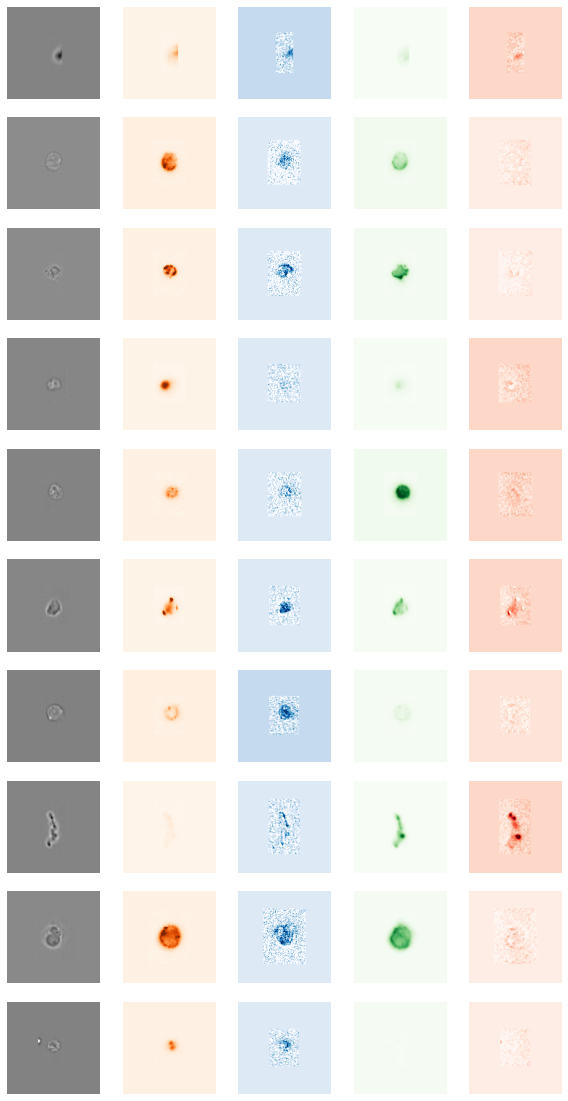

In [65]:

k = 10
image_size = 128
channels_to_be_plotted = [0,3,4,5,6]
channel_colors = ["Greys","Oranges" ,"Blues","Greens","Reds"]

cl = 3    
indx = metadata.cluster == cl
print(metadata.loc[indx, :])
files = metadata.loc[indx, "file"].sample(k,replace=True).tolist()

nrows = k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

                                                      file    experiment  \
1472     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
2836     /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
25993    /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
34631    /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
36681    /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1009970  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1035240  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1035551  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1055236  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1057270  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set    label  \
1472     Donor_1      

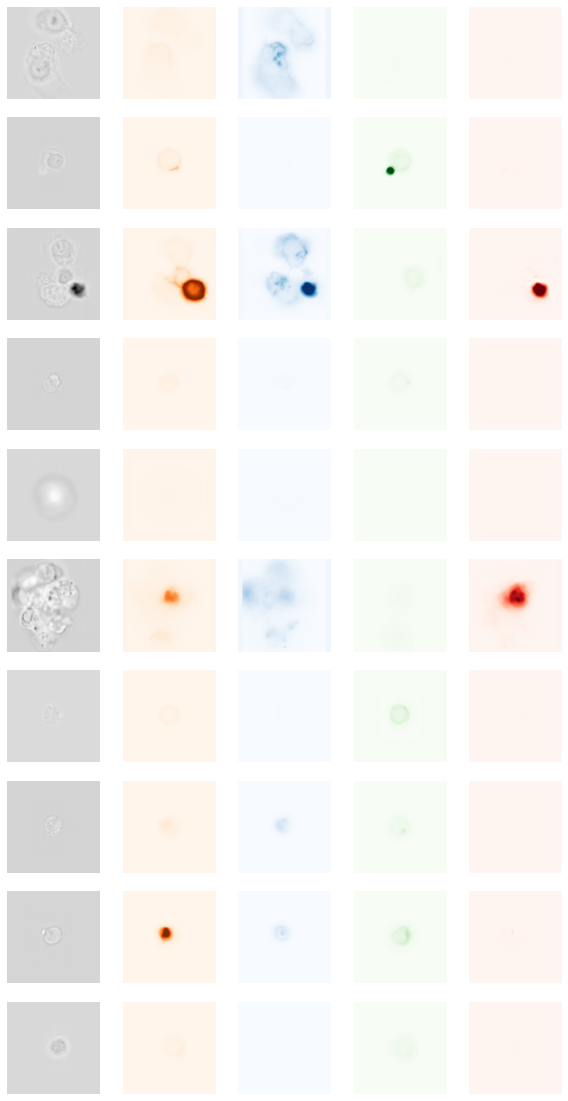

In [66]:

k = 10
image_size = 128
channels_to_be_plotted = [0,3,4,5,6]
channel_colors = ["Greys","Oranges" ,"Blues","Greens","Reds"]

cl = -1    
indx = metadata.cluster == cl
print(metadata.loc[indx, :])
files = metadata.loc[indx, "file"].sample(k,replace=True).tolist()

nrows = k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

#plt.savefig('Figure 2/ sample images.svg', bbox_inches="tight")

now we filtered out any cluster less than a 1% size

In [67]:

threshold = 0.01
for clus in metadata.cluster.unique():
    if (metadata.cluster == clus).mean() <= threshold:
        indx = metadata.cluster == clus
        metadata.loc[indx, "outlier"] = 1

In [68]:
metadata.to_csv("/pstore/data/DS4/synapse_data_features/metadata_subset_with_predictions.csv.gz" ,
           index=False, 
           compression="gzip")

# How many labeled sampled are needed

In [11]:
label_map = {'B_cell': 0,
                'T_cell': 1,
                'T_cell_with_signaling': 2,
                'T_cell_with_B_cell_fragments': 3,
                'B_T_cell_in_one_layer': 4,
                'Synapses_without_signaling': 5,
                'Synapses_with_signaling': 6,
                'No_cell_cell_interaction': 7,
                'Multiplets': 8,
                '-1': -1,
                -1: -1}

In [20]:
from sklearn.model_selection import train_test_split


f1_score_values = []
n_repeat = 10
top_k = 196
for _ in tqdm(range(n_repeat)):
    for train_size in range(5,100,5):
        X_train, _, y_train, _  = train_test_split(df_features.loc[train_index.tolist() + 
                                                             validation_index.tolist(), 
                                                             classification_indx], 
                                             metadata.loc[train_index.tolist() + 
                                                          validation_index.tolist(),
                                                          "label"].replace(label_map),
                                             train_size = train_size/100., 
                                             stratify = metadata.loc[train_index.tolist() + 
                                                                     validation_index.tolist(),
                                                                     "label"].replace(label_map))
        xgb_reduced = Pipeline([
                        ('StandardScaler', StandardScaler()), 
                        ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                         ('xgb', XGBClassifier(n_jobs = -1, 
                                               n_estimators = 100, 
                                               eval_metric = "logloss") )
                ], verbose=False)

        xgb_reduced.fit(X_train,  y_train )

        f1_score_values.append({
            "train_percentage" : train_size,
            "f1-macro" : f1_score(metadata.loc[test_index ,"label"].replace(label_map),
                                 xgb_reduced.predict(df_features.loc[test_index, classification_indx]),
                                 average = "macro"),

        })



  0%|          | 0/10 [00:00<?, ?it/s]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-992f94367bb8>", line 27, in <module>
    xgb_reduced.fit(X_train,  y_train )
  File "/home/shetabs1/.local/lib/python3.7/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/shetabs1/.local/lib/python3.7/site-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/home/shetabs1/.local/lib/python3.7/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/home/shetabs1/.local/lib/python3.7/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/shetabs1/.local/lib/python3.7/site-packages/sklearn/base.py", line 855, in fit_transform
    return self.fit(X, y,

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(f1_score_values).mean()

In [ ]:
round(pd.DataFrame(f1_score_values).std(),2)

In [ ]:
f1_score_values = pd.DataFrame(f1_score_values)


In [ ]:
fig, ax  = plt.subplots()

ax = sns.pointplot(data = f1_score_values,
        x = "train_percentage",
        y = "f1-macro",
        ax = ax) 

ax.set_yticks([0.80,0.85,0.90,0.95])
plt.savefig('Supplementary Figure - needed data for training the model pointplot.svg', bbox_inches="tight")
plt.savefig('Supplementary Figure - needed data for training the model pointplot.svg', bbox_inches="tight")

# Channel importance

In [ ]:
["_MHCII", "_P-CD3zeta", "_BF"]
["Live-Dead", "Antibody", "_CD3", "F-Actin", "CD18"]

array([ True,  True,  True, ..., False, False, False])

In [25]:
from sklearn.model_selection import train_test_split

classification_indx_minimal = classification_indx & (~df_features.columns.str.contains("Live-Dead") )
classification_indx_minimal = classification_indx & (~df_features.columns.str.contains("Antibody") )
classification_indx_minimal = classification_indx & (~df_features.columns.str.contains("_CD3") )
classification_indx_minimal = classification_indx & (~df_features.columns.str.contains("F-Actin") )
classification_indx_minimal = classification_indx & (~df_features.columns.str.contains("_CD18") )
print(classification_indx_minimal.sum())

f1_score_values = []
n_repeat = 1
top_k = 196
for _ in tqdm(range(n_repeat)):
    xgb_reduced = Pipeline([
                    ('StandardScaler', StandardScaler()), 
                    ('AutoFeatureSelection', AutoFeatureSelection( top_k = top_k )),
                     ('xgb', XGBClassifier(n_jobs = -1, 
                                           n_estimators = 100, 
                                           eval_metric = "logloss") )
            ], verbose=False)

    xgb_reduced.fit(df_features.loc[train_index.tolist() + validation_index.tolist(), classification_indx_minimal],  
                    metadata.loc[train_index.tolist() + validation_index.tolist() ,"label"].replace(label_map) )

    f1_score_values.append({
        "train_percentage" : train_size,
        "f1-macro" : f1_score(metadata.loc[test_index ,"label"].replace(label_map),
                             xgb_reduced.predict(df_features.loc[test_index, classification_indx_minimal]),
                             average = "macro"),

    })





  0%|          | 0/1 [00:00<?, ?it/s]

247






100%|██████████| 1/1 [00:42<00:00, 42.01s/it]


In [31]:
round(f1_score_values[0]['f1-macro'],2)

0.91

In [28]:
f1_score_values

[{'train_percentage': 50, 'f1-macro': 0.9141859309283693}]